In [4]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats

# Fichers CSV

In [5]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point') :
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(numeroPoints)

['point14_29_07_15', 'point15_29_07_15', 'schema_dispositif_AvAv_23_07_15.png', 'point47_27_08_19', 'point53_13_10_23', 'point52_13_10_23', 'point13_29_07_15', 'point36_12_07_16', 'point46_17_06_19', 'point34_27_06_16', 'point35_07_12_16', 'point48_14_04_18']
['14', '15', '47', '53', '52', '13', '36', '46', '34', '35', '48']


In [6]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [7]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = {}
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:4]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if (x.startswith('p') and x.endswith('.csv')) and not x.endswith('cleaned.csv') :
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    chemin_etalonnage = 'configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv'
    if os.path.exists(chemin_etalonnage):
        with open(chemin_etalonnage) as fichier :
            lignes = fichier.readlines()
            for l in lignes :
                if l.startswith('Intercept') :
                    dico['intercept'] = float(l[10:-2])
                if l.startswith('dU/dH') :
                    dico['dU/dH'] = float(l[6:-2])
                if l.startswith('dU/dT') :
                    dico['dU/dT'] = float(l[6:-2]) 
    data[dico['numero']] = dico


In [8]:
for x in data.values() :
    if x['pression'].empty :
        print('le point '+ x['numero'] + ' n\'a pas de données de pression, il n\'est pas valide')
        data.remove(x)

In [9]:
# pour les températures
for x in data.values() :
    # on supprime les colonnes qui ne servent à rien
    for i in x['temperature'].columns :
        if not( i.startswith(('Date', 'dates', 'temp','Temp'))) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith(('Date', 'dates', 'Tension', 'tension', 'pressure', 'temp', 'Temp'))) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP
    

In [10]:
from dateutil import parser

# Conversion dans le bon format date
for x in data.values():
    x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
    x['temperature']['dates'] = x['temperature']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
#    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='mixed')
#    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='mixed')

In [11]:
for x in data.values():
    x['to_process'] = pd.merge(x['pression'], x['temperature'], on='dates', how='inner')

In [12]:
for x in data.values() :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_process = [col for col in x['to_process'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['processed'] = x['to_process'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_process :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['to_process'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['to_process'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['processed'][column_name] = df_cleaned[column_name]

In [13]:
for x in data.values() :
    x['processed'] = x['processed'].dropna(axis = 0, how = 'any')

In [14]:
# Afficher les données de météo
chemin_fichier_texte = '/Users/lise_ps/Documents/_Mines/_Cours /T1/Molonari/Projet/MOLONARI_projet_3-/Meteo/BOISSY-METEO_PRCP.txt'
chemin_fichier_texte2 = '/Users/lise_ps/Documents/_Mines/_Cours /T1/Molonari/Projet/MOLONARI_projet_3-/Meteo/BOISSY-METEO_TEMPA.txt'

# Charger le fichier CSV dans une table de données (DataFrame)
pluie = pd.read_csv(chemin_fichier_texte, delimiter=';', skiprows=[0, 1])
temp = pd.read_csv(chemin_fichier_texte2, delimiter=';', skiprows=[0, 1])

# Enlever les colonnes 'Qualite', 'Min' et 'Max'
pluie = pluie.drop(['Qualite', 'Min', 'Max'], axis=1)
temp = temp.drop(['Qualite', 'Min', 'Max'], axis=1)

# Enlever les valeurs aberrantes
pluie = pluie[pluie['Valeur'] != -9999]
temp = temp[temp['Valeur'] != -9999]

# Convertir les dates en format datetime
pluie['DateHeure'] = pd.to_datetime(pluie['DateHeure'], format='%d/%m/%Y %H:%M:%S')
temp['DateHeure'] = pd.to_datetime(temp['DateHeure'], format='%d/%m/%Y %H:%M:%S')

print(pluie)
print(temp)

                 DateHeure  Valeur
823    1993-08-04 06:00:00     0.0
824    1993-08-04 07:00:00     0.0
825    1993-08-04 08:00:00     0.0
826    1993-08-04 09:00:00     0.0
827    1993-08-04 10:00:00     0.0
...                    ...     ...
256462 2022-10-02 21:00:00     0.0
256463 2022-10-02 22:00:00     0.0
256547 2022-10-06 10:00:00     0.0
256553 2022-10-06 16:00:00     0.2
256595 2022-10-08 10:00:00     0.0

[215954 rows x 2 columns]
                 DateHeure  Valeur
0      1993-06-30 23:00:00    15.2
6      1993-07-01 05:00:00    14.9
7      1993-07-01 06:00:00    16.5
9      1993-07-01 08:00:00    22.0
12     1993-07-01 11:00:00    23.5
...                    ...     ...
235211 2020-04-30 10:00:00    12.2
235212 2020-04-30 11:00:00    12.2
235213 2020-04-30 12:00:00    14.5
235214 2020-04-30 13:00:00    13.3
235215 2020-04-30 14:00:00    14.1

[205362 rows x 2 columns]


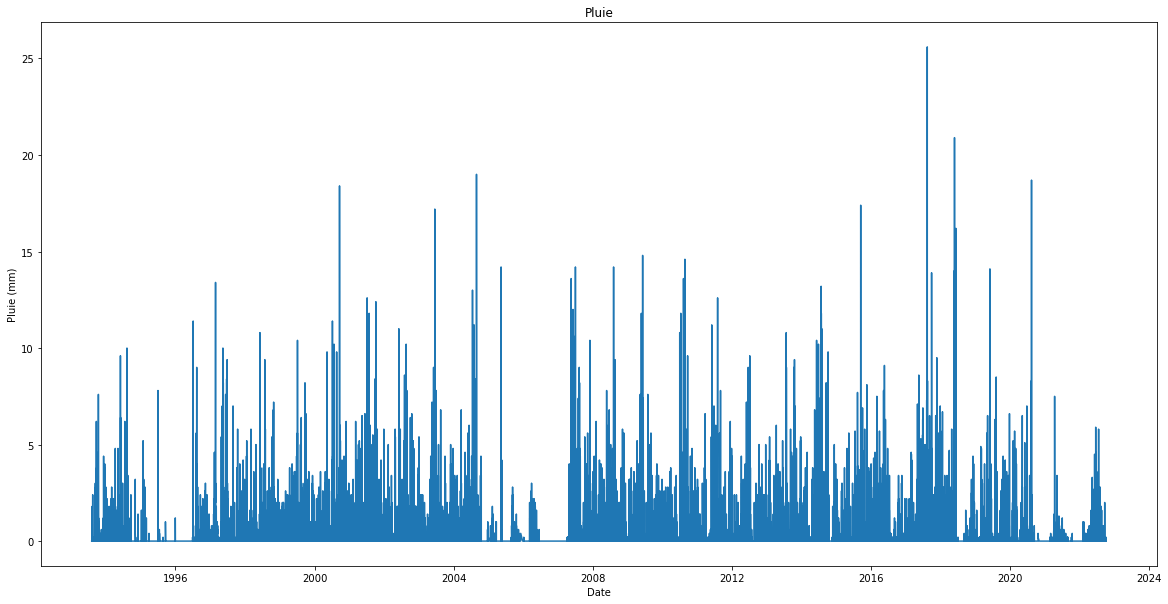

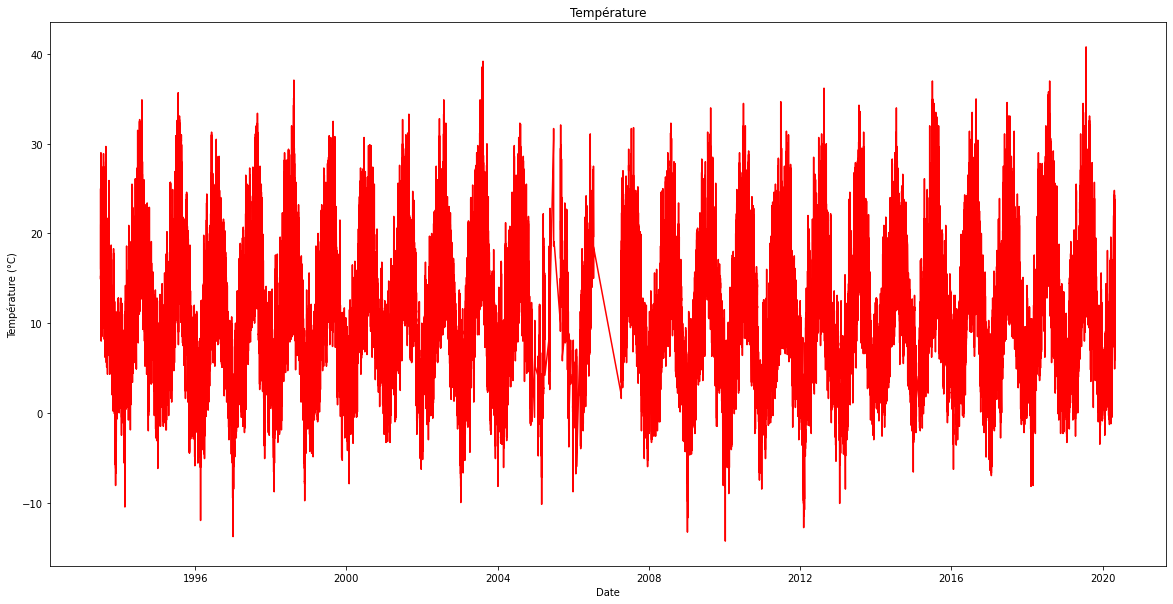

In [15]:
# Afficher le graphe de la pluie
plt.figure(figsize=(20,10))
plt.plot(pluie['DateHeure'], pluie['Valeur'])
plt.xlabel('Date')
plt.ylabel('Pluie (mm)')
plt.title('Pluie')
plt.show()

# Afficher le graphe de la température
plt.figure(figsize=(20,10))
plt.plot(temp['DateHeure'], temp['Valeur'], color='red')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Température')
plt.show()



In [16]:
# Créer une colonne pour le mois
pluie['Mois'] = pluie['DateHeure'].dt.month

# Créer une colonne pour l'année
pluie['Annee'] = pluie['DateHeure'].dt.year

# Calculer la moyenne des précipitations par mois pour toutes les années
moyenne_mensuelle = pluie.groupby('Mois')['Valeur'].mean().reset_index()

# Ajouter une colonne pour le nom du mois
moyenne_mensuelle['NomMois'] = moyenne_mensuelle['Mois'].apply(lambda x: calendar.month_abbr[x])

# Afficher le graphique en barres de la moyenne mensuelle
plt.figure(figsize=(20, 10))
sns.barplot(x='NomMois', y='Valeur', data=moyenne_mensuelle, color='blue', alpha=0.7)

plt.xlabel('Mois')
plt.ylabel('Moyenne mensuelle des précipitations (mm)')
plt.title('Moyenne mensuelle des précipitations pour toutes les années')
plt.show()


NameError: name 'calendar' is not defined

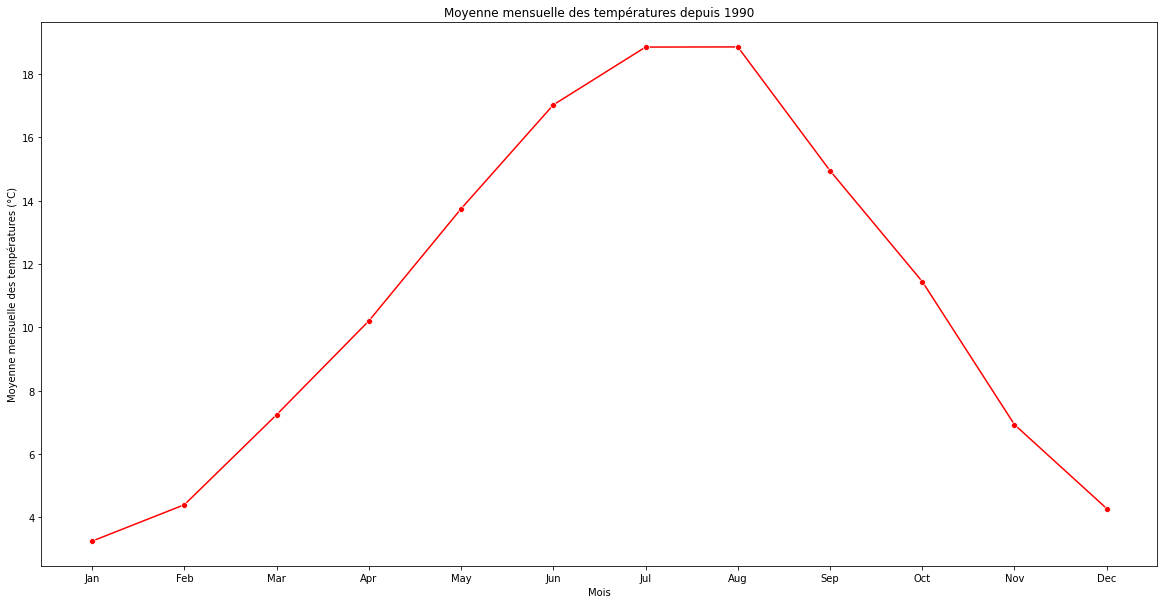

In [ ]:
# Créer une colonne pour le mois
temp['Mois'] = temp['DateHeure'].dt.month

# Créer une colonne pour l'année
temp['Annee'] = temp['DateHeure'].dt.year

# Calculer la moyenne des températures par mois pour toutes les années
moyenne_mensuelle = temp.groupby('Mois')['Valeur'].mean().reset_index()

# Ajouter une colonne pour le nom du mois
moyenne_mensuelle['NomMois'] = moyenne_mensuelle['Mois'].apply(lambda x: calendar.month_abbr[x])

# Afficher le graphique en courbe de la moyenne mensuelle
plt.figure(figsize=(20, 10))
sns.lineplot(x='NomMois', y='Valeur', data=moyenne_mensuelle, color='red', marker='o')

plt.xlabel('Mois')
plt.ylabel('Moyenne mensuelle des températures (°C)')
plt.title('Moyenne mensuelle des températures depuis 1990')
plt.show()


In [ ]:
import pandas as pd

# Chemin d'accès au fichier CSV
chemin_fichier = "/Users/lise_ps/Documents/_Mines/_Cours /T1/Molonari/Projet/MOLONARI_projet_3-/Meteo/BOISSY-METEO_OCT.csv"

# Lire le fichier CSV
data = pd.read_csv(chemin_fichier, sep=';')

# Sélectionner les colonnes nécessaires
nouvelles_colonnes = ['Jour', 'Temperature moy.', 'Precipitations']
nouvelle_table = data[nouvelles_colonnes]

# Afficher la nouvelle table de données
print(nouvelle_table)

# Calculer la moyenne des précipitations
moyenne_precipitations = nouvelle_table['Precipitations'].mean()

# Afficher la moyenne des précipitations
print("Moyenne des précipitations : ", moyenne_precipitations, " mm")


             Jour  Temperature moy.  Precipitations
0   \tDimanche 01              20.0             0.0
1        Lundi 02              21.5             0.0
2        Mardi 03              18.5             1.0
3     Mercredi 04              14.0             0.0
4        Jeudi 05              15.5             0.0
5     Vendredi 06              15.5             0.0
6       Samedi 07              17.0             0.0
7     Dimanche 08              20.0             0.2
8        Lundi 09              20.0             0.0
9        Mardi 10              20.0             0.0
10    Mercredi 11              19.0             0.0
11       Jeudi 12              19.5             3.9
12    Vendredi 13              21.0             2.0
13      Samedi 14              13.5             0.1
14    Dimanche 15              11.0             0.0
15       Lundi 16               9.5             0.0
16       Mardi 17              11.0             0.4
17    Mercredi 18              14.5             5.6
18       Jeu

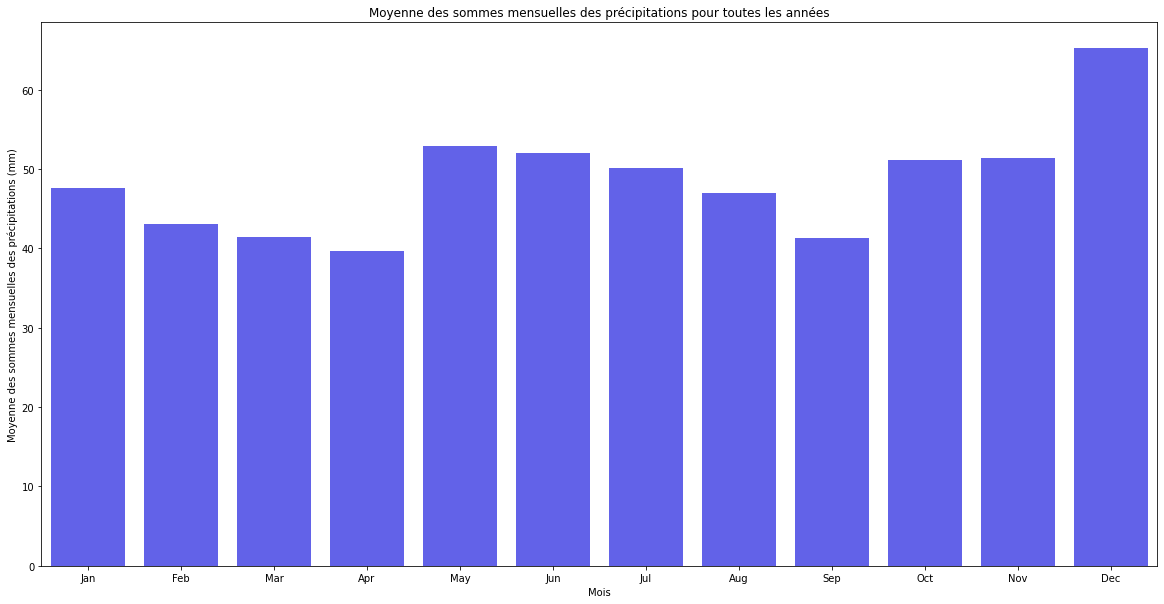

In [ ]:
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

# Créer une colonne pour le mois
pluie['Mois'] = pluie['DateHeure'].dt.month

# Créer une colonne pour l'année
pluie['Annee'] = pluie['DateHeure'].dt.year

# Calculer la somme des précipitations par mois pour toutes les années
somme_mensuelle = pluie.groupby(['Annee', 'Mois'])['Valeur'].sum().reset_index()

# Calculer la moyenne des sommes des précipitations par mois
moyenne_somme_mensuelle = somme_mensuelle.groupby('Mois')['Valeur'].mean().reset_index()

# Ajouter une colonne pour le nom du mois
moyenne_somme_mensuelle['NomMois'] = moyenne_somme_mensuelle['Mois'].apply(lambda x: calendar.month_abbr[x])

# Afficher le graphique en barres de la moyenne des sommes des précipitations mensuelles
plt.figure(figsize=(20, 10))
sns.barplot(x='NomMois', y='Valeur', data=moyenne_somme_mensuelle, color='blue', alpha=0.7)

plt.xlabel('Mois')
plt.ylabel('Moyenne des sommes mensuelles des précipitations (mm)')
plt.title('Moyenne des sommes mensuelles des précipitations pour toutes les années')
plt.show()


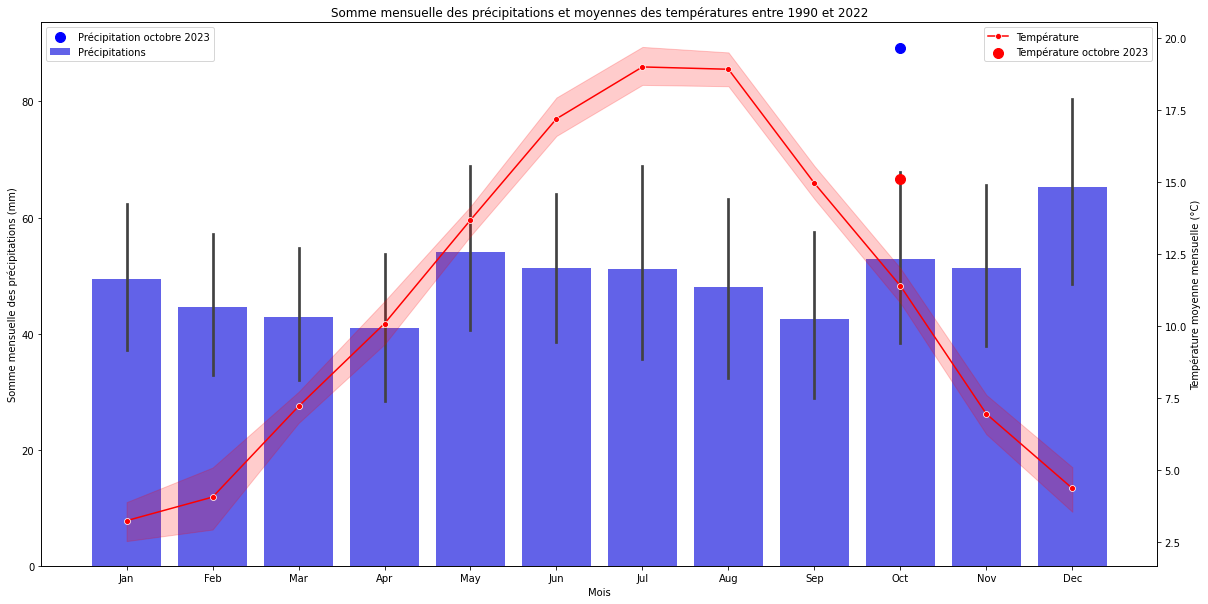

In [ ]:
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# Créer une colonne pour le mois dans temp
temp['Mois'] = temp['DateHeure'].dt.month

# Créer une colonne pour l'année dans temp
temp['Annee'] = temp['DateHeure'].dt.year

# Filtrer les données pour les années civiles complètes
temp = temp[(temp['DateHeure'] >= '1990-01-01') & (temp['DateHeure'] < '2022-01-01')]

# Calculer la moyenne des températures par mois pour toutes les années
moyenne_mensuelle_temperature = temp.groupby(['Annee', 'Mois'])['Valeur'].mean().reset_index()

# Créer une colonne pour le nom du mois dans temp
moyenne_mensuelle_temperature['NomMois'] = moyenne_mensuelle_temperature['Mois'].apply(lambda x: calendar.month_abbr[x])

# Corriger le décalage des mois pour la température
moyenne_mensuelle_temperature['NomMois'] = pd.Categorical(moyenne_mensuelle_temperature['NomMois'], categories=order, ordered=True)

# Afficher le graphique en barres de la somme mensuelle des précipitations
plt.figure(figsize=(20, 10))
ax1 = sns.barplot(x='NomMois', y='Valeur', data=somme_mensuelle_precipitations, color='blue', alpha=0.7, label='Précipitations')

# Créer un axe y secondaire pour afficher la courbe des températures
ax2 = ax1.twinx()
sns.lineplot(x='NomMois', y='Valeur', data=moyenne_mensuelle_temperature, color='red', marker='o', label='Température')

ax1.set_xlabel('Mois')
ax1.set_ylabel('Somme mensuelle des précipitations (mm)')
ax2.set_ylabel('Température moyenne mensuelle (°C)')

plt.title('Somme mensuelle des précipitations et moyennes des températures entre 1990 et 2022')

# Ajouter des points isolés pour mai 2023
mai_2023_precipitation = 89.2
mai_2023_temperature = 15.1

# Trouver le mois d'mai dans le DataFrame pour obtenir la position sur l'axe x
position_mai = somme_mensuelle_precipitations[somme_mensuelle_precipitations['NomMois'] == 'May']['NomMois'].index[0]

# Ajouter les points sur le graphique
ax1.scatter(position_mai, mai_2023_precipitation, color='blue', s=100, label='Précipitation octobre 2023')
ax2.scatter(position_mai, mai_2023_temperature, color='red', s=100, label='Température octobre 2023')

# Réafficher la légende
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Spécifier l'ordre des mois dans l'axe des x
plt.xticks(range(12), order)

# Afficher le graphe combiné
plt.show()


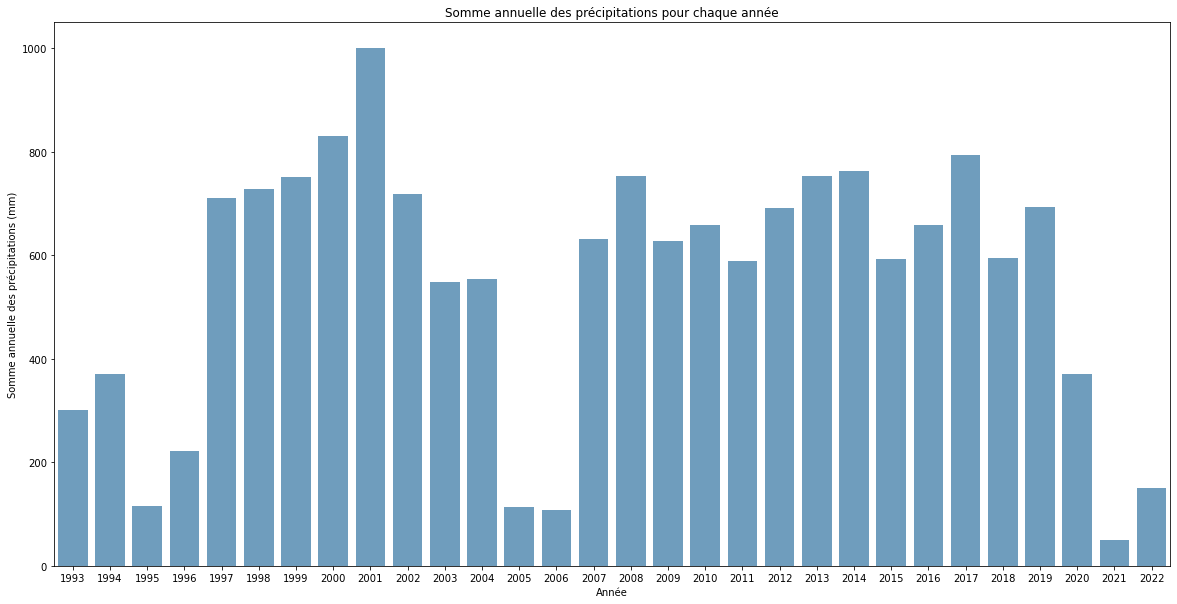

In [ ]:
# Créer une colonne pour l'année
pluie['Annee'] = pluie['DateHeure'].dt.year

# Calculer la somme des précipitations par année
somme_annuelle = pluie.groupby('Annee')['Valeur'].sum().reset_index()

# Afficher le graphique en barres de la somme des précipitations par année
plt.figure(figsize=(20, 10))
sns.barplot(x='Annee', y='Valeur', data=somme_annuelle, color='#1f78b4', alpha=0.7)

plt.xlabel('Année')
plt.ylabel('Somme annuelle des précipitations (mm)')
plt.title('Somme annuelle des précipitations pour chaque année')
plt.show()


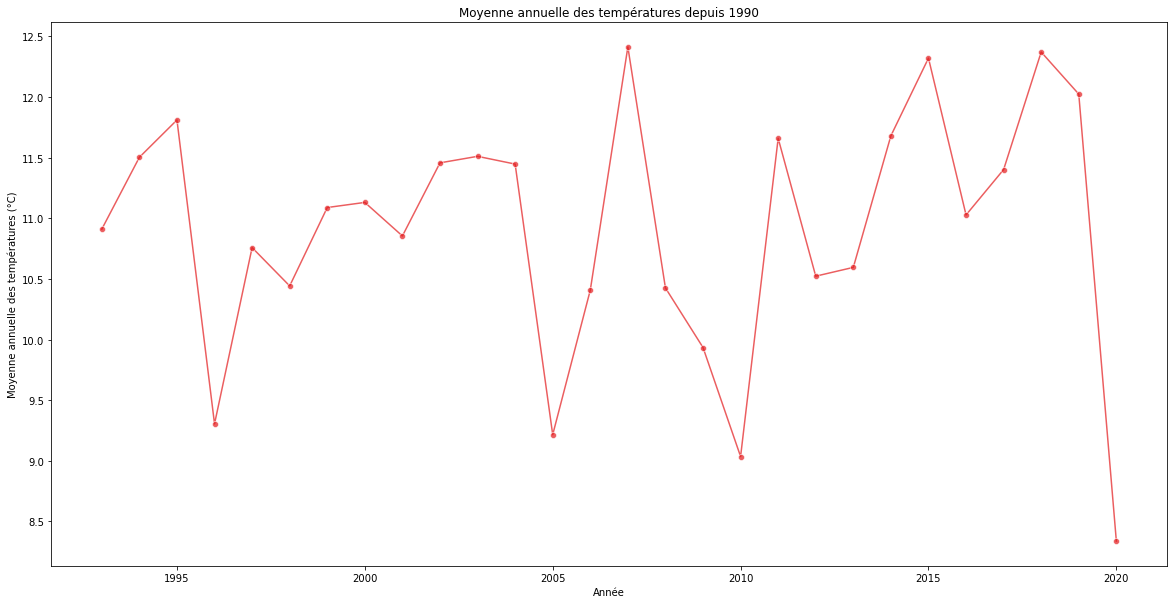

In [ ]:
# Moyenne des températures par année

# Créer une colonne pour l'année
temp['Annee'] = temp['DateHeure'].dt.year

# Calculer la moyenne des températures par année
moyenne_annuelle = temp.groupby('Annee')['Valeur'].mean().reset_index()

# Afficher le graphique en barres de la moyenne des températures par année
plt.figure(figsize=(20, 10))
sns.lineplot(x='Annee', y='Valeur', data=moyenne_annuelle, color='#e31a1c', marker='o', alpha=0.7)

plt.xlabel('Année')
plt.ylabel('Moyenne annuelle des températures (°C)')
plt.title('Moyenne annuelle des températures depuis 1990')
plt.show()

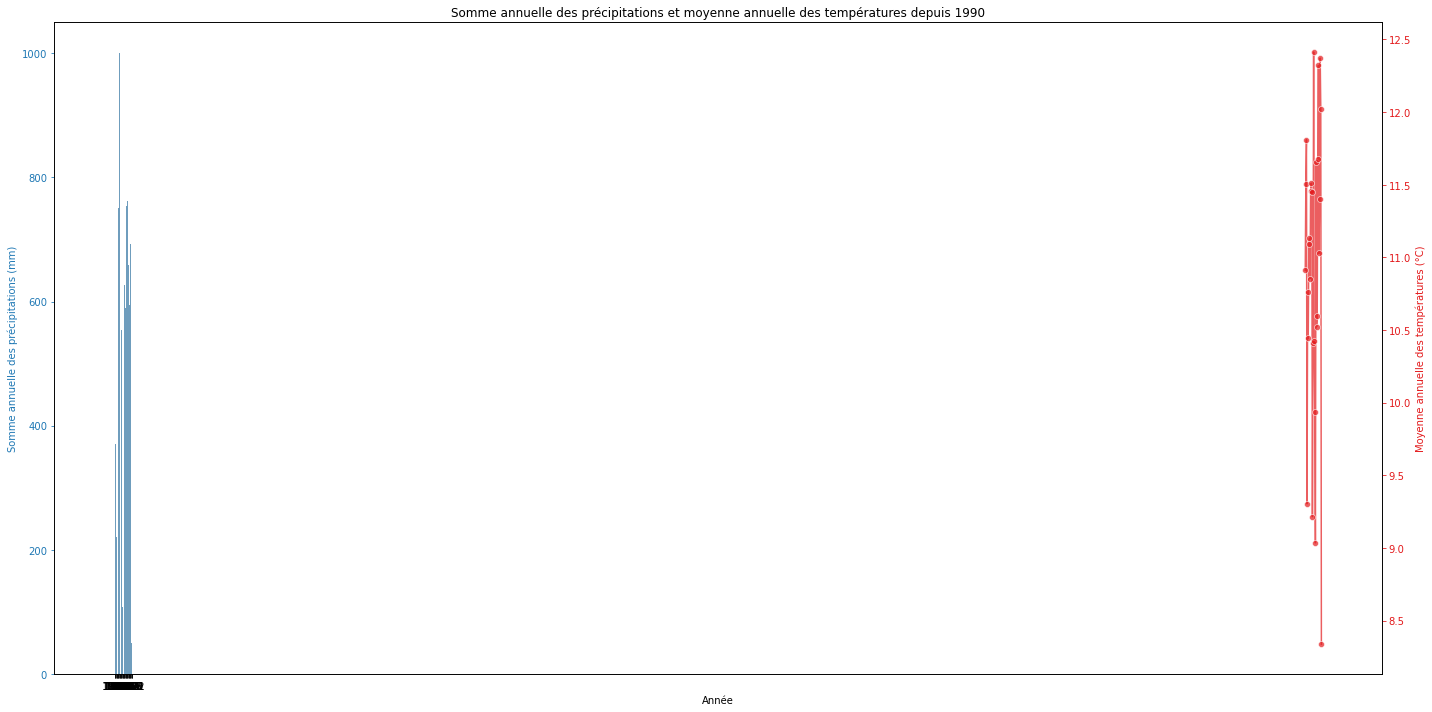

In [ ]:
# Filtrer les données de température pour les années civiles complètes
temp = temp[(temp['DateHeure'] >= '1990-01-01') & (temp['DateHeure'] < '2022-01-01')]

# Calculer la moyenne des températures par année pour toutes les années civiles
moyenne_annuelle_temperature = temp.groupby('Annee')['Valeur'].mean().reset_index()

# Créer une figure et un axe principal
fig, ax1 = plt.subplots(figsize=(20, 10))

# Tracer la somme des précipitations sur l'axe y principal
sns.barplot(x='Annee', y='Valeur', data=somme_annuelle, color='#1f78b4', alpha=0.7, ax=ax1)

# Configurer les étiquettes et le titre pour l'axe y principal
ax1.set_xlabel('Année')
ax1.set_ylabel('Somme annuelle des précipitations (mm)', color='#1f78b4')
ax1.tick_params('y', colors='#1f78b4')
ax1.set_title('Somme annuelle des précipitations et moyenne annuelle des températures depuis 1990')

# Créer un deuxième axe y
ax2 = ax1.twinx()

# Tracer la moyenne des températures sur l'axe y secondaire
sns.lineplot(x='Annee', y='Valeur', data=moyenne_annuelle_temperature, color='#e31a1c', marker='o', alpha=0.7, ax=ax2)

# Configurer les étiquettes et le titre pour l'axe y secondaire
ax2.set_ylabel('Moyenne annuelle des températures (°C)', color='#e31a1c')
ax2.tick_params('y', colors='#e31a1c')

# Ajuster l'espace entre les deux axes
fig.tight_layout()

# Afficher le graphe combiné
plt.show()


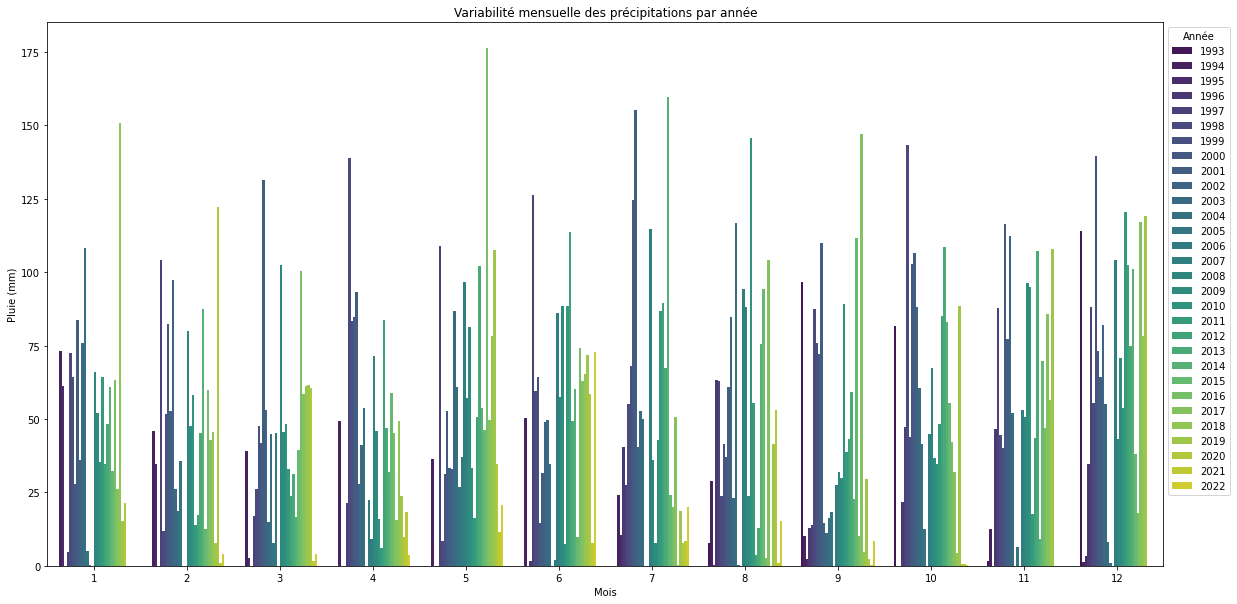

In [ ]:
import seaborn as sns

# Créer une colonne pour le mois
pluie['Mois'] = pluie['DateHeure'].dt.month

# Créer une colonne pour l'année
pluie['Annee'] = pluie['DateHeure'].dt.year

# Calculer la somme des précipitations par mois et par année
pluie_mensuelle = pluie.groupby(['Annee', 'Mois'])['Valeur'].sum().reset_index()

# Afficher le graphique en barres avec différentes couleurs pour chaque année
plt.figure(figsize=(20, 10))
sns.barplot(x='Mois', y='Valeur', hue='Annee', data=pluie_mensuelle, palette='viridis')
plt.xlabel('Mois')
plt.ylabel('Pluie (mm)')
plt.title('Variabilité mensuelle des précipitations par année')
plt.legend(title='Année', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
# Créer une colonne pour l'année dans chaque DataFrame
pluie['Annee'] = pluie['DateHeure'].dt.year
temp['Annee'] = temp['DateHeure'].dt.year

# Calculer la somme des précipitations par année
somme_annuelle_pcp = pluie.groupby('Annee')['Valeur'].sum().reset_index()

# Calculer la moyenne des températures par année
moyenne_annuelle_temp = temp.groupby('Annee')['Valeur'].mean().reset_index()

# Fusionner les deux tableaux sur la colonne 'Annee'
tableau_combine = pd.merge(somme_annuelle_pcp, moyenne_annuelle_temp, on='Annee', how='outer')

# Renommer les colonnes
tableau_combine = tableau_combine.rename(columns={'Valeur_x': 'Somme_Pluie', 'Valeur_y': 'Temp_Moyenne'})

# Afficher le tableau combiné
print(tableau_combine)



    Annee  Somme_Pluie  Temp_Moyenne
0    1993        301.8     10.910462
1    1994        370.2     11.503221
2    1995        115.6     11.810909
3    1996        221.2      9.304224
4    1997        709.8     10.758335
5    1998        727.4     10.442066
6    1999        751.6     11.088856
7    2000        829.8     11.130982
8    2001       1000.0     10.854315
9    2002        718.2     11.457352
10   2003        549.0     11.511136
11   2004        554.0     11.447214
12   2005        113.8      9.215007
13   2006        107.1     10.407411
14   2007        631.0     12.413787
15   2008        752.0     10.425496
16   2009        627.0      9.934166
17   2010        658.9      9.034844
18   2011        589.0     11.659603
19   2012        691.0     10.522573
20   2013        753.4     10.595063
21   2014        761.8     11.680597
22   2015        592.8     12.321059
23   2016        659.0     11.027664
24   2017        792.7     11.402036
25   2018        594.7     12.371632
2

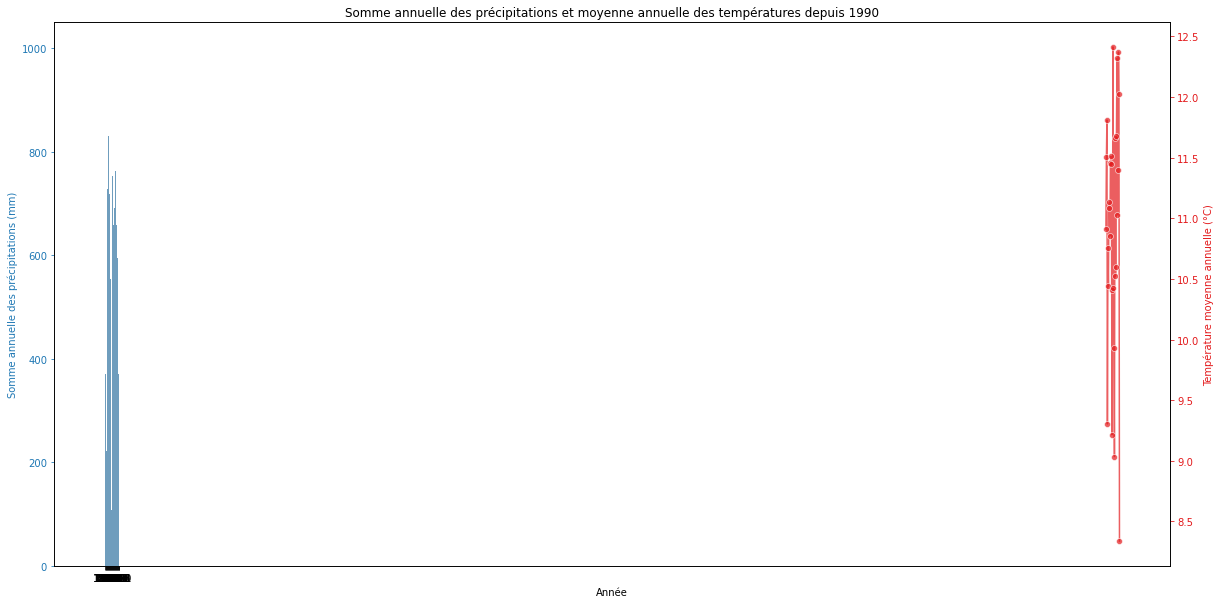

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer une figure et un axe principal
fig, ax1 = plt.subplots(figsize=(20, 10), sharex=True)

# Tracer la somme des précipitations sur l'axe y principal (en bleu)
sns.barplot(x='Annee', y='Somme_Pluie', data=tableau_combine, color='#1f78b4', alpha=0.7, ax=ax1)

# Configurer les étiquettes et le titre pour l'axe y principal
ax1.set_xlabel('Année')
ax1.set_ylabel('Somme annuelle des précipitations (mm)', color='#1f78b4')
ax1.tick_params('y', colors='#1f78b4')
ax1.set_title('Somme annuelle des précipitations et moyenne annuelle des températures depuis 1990')

# Créer un deuxième axe y
ax2 = ax1.twinx()

# Tracer la moyenne des températures sur l'axe y secondaire (en rouge)
sns.lineplot(x='Annee', y='Temp_Moyenne', data=tableau_combine, color='#e31a1c', marker='o', alpha=0.7, ax=ax2)

# Configurer les étiquettes et le titre pour l'axe y secondaire
ax2.set_ylabel('Température moyenne annuelle (°C)', color='#e31a1c')
ax2.tick_params('y', colors='#e31a1c')

# Ajuster l'espace entre les deux axes
#fig.tight_layout()

# Afficher le graphe combiné
plt.show()


In [ ]:
# Spécifiez le chemin et le nom du fichier Excel de sortie
chemin_fichier_excel = '/Users/lise_ps/Documents/_Mines/_Cours /T1/Molonari/Projet/MOLONARI_projet_3-/Meteo/Data_Meteo.xlsx'

# Exportez le DataFrame vers Excel
tableau_combine.to_excel(chemin_fichier_excel, index=False)


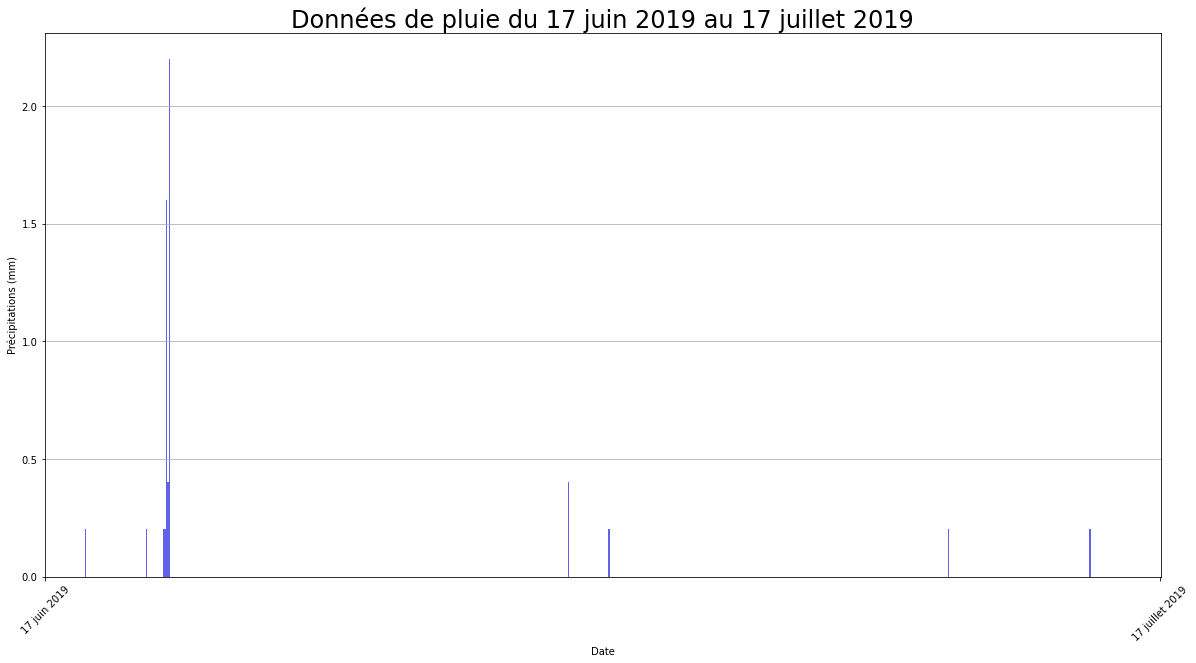

In [33]:
# Filtrer les données pour la période spécifiée
pluie_periode = pluie[(pluie['DateHeure'] >= '2019-06-17') & (pluie['DateHeure'] <= '2019-07-17')]

# Créer le graphique en barres
plt.figure(figsize=(20, 10))
sns.barplot(x='DateHeure', y='Valeur', data=pluie_periode, color='blue', alpha=0.7)

# Ajouter les étiquettes "17 juin 2019" au début et "17 juillet 2019" à la fin de l'axe des abscisses
plt.xticks([0, len(pluie_periode)-1], ['17 juin 2019', '17 juillet 2019'], rotation=45)

plt.xlabel('Date')
plt.ylabel('Précipitations (mm)')

# Modifier la taille du titre
plt.title('Données de pluie du 17 juin 2019 au 17 juillet 2019', fontsize=24)

plt.grid(axis='y')
plt.show()